# فاز 1

## بارگذاری داده ها

In [1]:
!pip install kagglehub[pandas-datasets]


In [2]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd


# Set the path to the file you'd like to load
file_path = "ecommerceDataset.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "saurabhshahane/ecommerce-text-classification",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

/tmp/ipython-input-2-3445686076.py:12: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


First 5 records:    Household  \
0  Household   
1  Household   
2  Household   
3  Household   
4  Household   

  Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch. This painting is ready to hang, you would be proud to possess this unique painting that is a niche apart. We use only the most modern and efficient printing technology on our prints, with only the and inks and precision epson, roland and hp printers. This innovative hd printing technique results in durable and spectacular looking prints of the highest that last a lifetime. We print solely with top-notch 100% inks, to achieve brilliant and true colours. Due to their high level of uv resistance, our prints retain their beautiful colours for many years. Add colour a

In [3]:
import pandas as pd

# مسیر فایل
file_path = "/kaggle/input/ecommerce-text-classification/ecommerceDataset.csv"

# بارگذاری داده‌ها با تعیین نام ستون‌ها
df = pd.read_csv(file_path, header=None, names=["category", "text"])
#کم کردن حجم داده ها
df = df.sample(n=5000, random_state=42)
# نمایش ۵ نمونه اول
df.head()


,category,text
35848,Clothing & Accessories,Kandy Men's Regular Fit Blazer Blue This produ...
13005,Household,HealthSense Chef-Mate KS 50 Digital Kitchen Sc...
22719,Books,Concept of Physics (2018-2019) Session (Set of...
18453,Household,Lista Stainless Steel Multi Functional Hammer ...
20867,Books,Gardening in Urban India update


In [ ]:
df.columns = ["category", "text"]
df.head()

## تابع پیش‌پردازش متن

In [4]:
import re
import string
import nltk

nltk.download("stopwords")   # کلمات توقف (Stopwords)
nltk.download("punkt")       # برای توکن‌سازی متن
nltk.download("wordnet")     # برای Lemmatization

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [5]:
def preprocess(text):
    # اطمینان از اینکه ورودی رشته است
    if not isinstance(text, str):
        return ""

    stop_words = set(stopwords.words("english"))  # ساختن مجموعه کلمات توقف
    lemmatizer = WordNetLemmatizer()              # ایجاد آبجکت برای مثلا تبدیل فعل ها به ریشه

    # lowercase
    text = text.lower()

    # حذف URLها
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)

    # حذف ایمیل‌ها
    text = re.sub(r'\S+@\S+', '', text)

    # حذف اعداد تنها یا ترکیب‌شده
    text = re.sub(r'\b\d+\b', '', text)

    # حذف HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # حذف punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)

    # حذف کاراکترهای تکراری کش‌دار (مثلاً soooo → so)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # حذف فضای اضافه بین کلمات
    text = re.sub(r'\s+', ' ', text).strip()

    # split (توکن‌سازی ساده)
    tokens = text.split()

    # حذف stopwords و Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]

    return ' '.join(tokens)



In [6]:
# اعمال پیش‌پردازش
df["clean_text"] = df["text"].apply(preprocess)

# نمایش نمونه‌ها
df[["text", "clean_text"]].head()


,text,clean_text
35848,Kandy Men's Regular Fit Blazer Blue This produ...,kandy men regular fit blazer blue product made...
13005,HealthSense Chef-Mate KS 50 Digital Kitchen Sc...,healthsense chefmate digital kitchen scale grey
22719,Concept of Physics (2018-2019) Session (Set of...,concept physic session set volume
18453,Lista Stainless Steel Multi Functional Hammer ...,lista stainless steel multi functional hammer ...
20867,Gardening in Urban India update,gardening urban india update


# فاز 2

##TF-IDF

In [7]:
import numpy as np
from collections import Counter, defaultdict
import math

# متون تمیز شده
documents = df["clean_text"].tolist()
N = len(documents)  # تعداد کل اسناد

# 1. محاسبه DF برای هر واژه
df_counts = defaultdict(int)  # document frequency

for doc in documents:
    unique_words = set(doc.split())
    for word in unique_words:
        df_counts[word] += 1

# 2. محاسبه IDF برای هر واژه
idf = {}
for word, df_count in df_counts.items():
    idf[word] = math.log(N / (1 + df_count))  # افزودن 1 برای جلوگیری از تقسیم بر صفر


In [8]:
# تمام کلمات موجود (واژگان نهایی)
vocab = sorted(idf.keys())
word2idx = {word: idx for idx, word in enumerate(vocab)}

# ایجاد ماتریس ویژگی N × V
tfidf_matrix = np.zeros((N, len(vocab)))

for i, doc in enumerate(documents):
    word_counts = Counter(doc.split())
    total_words = sum(word_counts.values())

    for word, count in word_counts.items():
        if word in idf:
            tf = count / total_words
            tfidf_matrix[i, word2idx[word]] = tf * idf[word]


In [ ]:
#print the first one
print(documents[0])  # سند پیش‌پردازش شده
for word in documents[0].split():
    if word in idf:
        print(word, "→ tf-idf:", idf[word])
    else:
        print(word, "❌ not in vocab")



kandy men regular fit blazer blue product made velvet finished attractive blue color feature plain solid pattern long sleeve buttoned closure targeted towards men furthermore recommended kept away extreme heat fire corrosive liquid avoid form damage
kandy → tf-idf: 7.824046010856292
men → tf-idf: 2.8134107167600364
regular → tf-idf: 3.519980917652122
fit → tf-idf: 2.501036031717884
blazer → tf-idf: 5.626821433520073
blue → tf-idf: 2.9603651297166995
product → tf-idf: 1.7070507413011007
made → tf-idf: 1.789761466565382
velvet → tf-idf: 5.8781358618009785
finished → tf-idf: 4.06284589516273
attractive → tf-idf: 3.519980917652122
blue → tf-idf: 2.9603651297166995
color → tf-idf: 1.9589953886039688
feature → tf-idf: 2.0826466726287842
plain → tf-idf: 4.406319327242926
solid → tf-idf: 3.649658740960655
pattern → tf-idf: 3.4357888264317746
long → tf-idf: 2.4557362724882204
sleeve → tf-idf: 3.789805372703897
buttoned → tf-idf: 6.907755278982137
closure → tf-idf: 5.051457288616511
targeted → t

## word2vec

In [9]:
!pip install gensim

In [10]:
#وارد کردن کتابخانه‌ها و آماده‌سازی داده‌ها


import nltk
nltk.download('punkt_tab')  # یا nltk.download('punkt')

from nltk.tokenize import word_tokenize

sentences = df["clean_text"].apply(word_tokenize).tolist()



[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [11]:
# آموزش مدل Word2Vec
# vector_size: اندازه بردار خروجی هر کلمه (مثلاً 100)
# window: تعداد کلماتی که قبل و بعد کلمه را در نظر می‌گیرد (مثلاً 5)
# min_count: حداقل تعداد تکرار یک کلمه برای وارد شدن به مدل (مثلاً 2)
# workers: تعداد هسته‌های پردازشی

#mobina
from gensim.models import Word2Vec

model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)


In [12]:
# بردار عددی کلمه "painting"
vector = model.wv['painting']
print(f"Vector for 'painting':\n{vector}\n")

# تشخیص شباهت بین دو کلمه
similarity = model.wv.similarity('painting', 'art')
print(f"Similarity between 'painting' and 'art': {similarity}")

# یافتن کلمات نزدیک به "painting"
similar_words = model.wv.most_similar('painting', topn=5)
print("Most similar words to 'painting':")
for word, score in similar_words:
    print(f"{word}: {score}")


Vector for 'painting':
[-0.20872644  0.31104589  0.19418222  0.14605707 -0.0111544  -0.50578326
  0.21616444  0.433778   -0.23935573 -0.21622503 -0.16817513 -0.5869771
 -0.08036816  0.01711743  0.00632932 -0.25004306  0.10143535 -0.42975077
  0.27207422 -0.5603581   0.2220431   0.11555542  0.27530062 -0.09837995
 -0.09457247 -0.04416937 -0.22989115 -0.22992137 -0.10149078 -0.17900065
  0.38553816 -0.02960352  0.01100453 -0.13652381 -0.05788901  0.43457854
 -0.07426816 -0.33774355 -0.19728889 -0.5305196   0.08460288 -0.3351593
 -0.06722469  0.12805973  0.32416967 -0.09148487 -0.45661262 -0.09481912
  0.21275994  0.16583811  0.15751019 -0.18146592 -0.09847596 -0.05095236
 -0.28599954  0.23526466  0.06391845 -0.2725424  -0.51750135  0.13093168
  0.03423328  0.21341494 -0.23890217  0.06679886 -0.2255078   0.23359255
  0.10716908  0.22340055 -0.32258877  0.29358524 -0.16140796  0.17174831
  0.40528908 -0.23996243  0.4045095   0.20366023  0.01860061 -0.07103775
 -0.2917513   0.22211066 -0.27

# فاز 3 و 4


In [13]:
import numpy as np

# ذخیره به صورت فایل .npy
np.save("tfidf_matrix.npy", tfidf_matrix)

# ذخیره واژگان برای نگه‌داشتن mapping
import pickle
with open("word2idx.pkl", "wb") as f:
    pickle.dump(word2idx, f)


In [ ]:
import numpy as np

# بارگذاری ماتریس TF-IDF
tfidf_matrix = np.load("tfidf_matrix.npy")
import pickle

# بارگذاری دیکشنری واژگان
with open("word2idx.pkl", "rb") as f:
    word2idx = pickle.load(f)


## tf-idf


🧪 Random Forest
Accuracy: 0.921
                        precision    recall  f1-score   support

                 Books       0.91      0.93      0.92       237
Clothing & Accessories       0.98      0.93      0.95       189
           Electronics       0.93      0.87      0.90       202
             Household       0.90      0.94      0.92       372

              accuracy                           0.92      1000
             macro avg       0.93      0.92      0.92      1000
          weighted avg       0.92      0.92      0.92      1000
 

🧪 Linear SVC
Accuracy: 0.944
                        precision    recall  f1-score   support

                 Books       0.95      0.92      0.94       237
Clothing & Accessories       0.97      0.96      0.97       189
           Electronics       0.90      0.93      0.92       202
             Household       0.95      0.95      0.95       372

              accuracy                           0.94      1000
             macro avg       0.94   

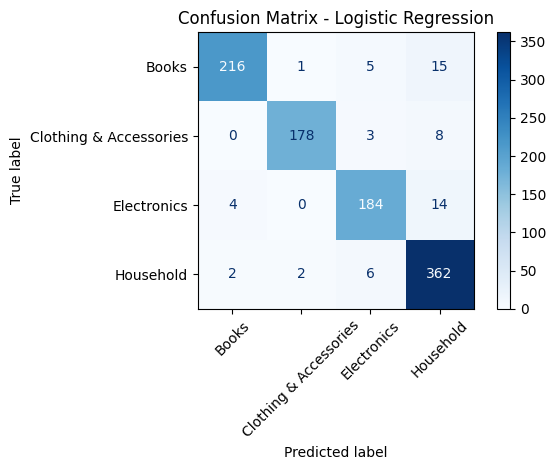

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

X = tfidf_matrix  # ← داده‌های بردارسازی‌شده با TF-IDF
y = df["category"]  # ← برچسب دسته‌بندی

import numpy as np

indices = np.arange(len(df))
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, indices, test_size=0.2, random_state=42
)


models = {
    "Random Forest": RandomForestClassifier(),
    "Linear SVC": LinearSVC(),
    # "MLP Classifier": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300)
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

for name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(f"🧪 {name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred), "\n")

    # فقط برای Logistic Regression ماتریس رسم شود
    if name == "Logistic Regression":
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                    display_labels=clf.classes_)
        disp.plot(cmap='Blues', values_format='d')
        plt.title('Confusion Matrix - Logistic Regression')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()



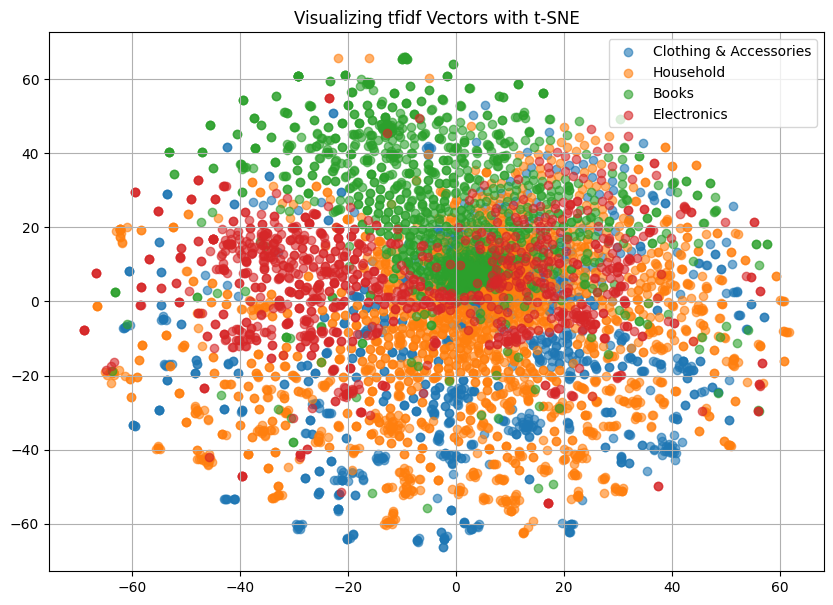

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


X_vis = tfidf_matrix

# کاهش ابعاد با t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_2d = tsne.fit_transform(X_vis)

# رسم
plt.figure(figsize=(10, 7))
for label in df["category"].unique():
    indices = df["category"] == label
    plt.scatter(X_2d[indices, 0], X_2d[indices, 1], label=label, alpha=0.6)

plt.legend()
plt.title("Visualizing tfidf Vectors with t-SNE")
plt.grid(True)
plt.show()


🔍 Predicted Class: Clothing & Accessories


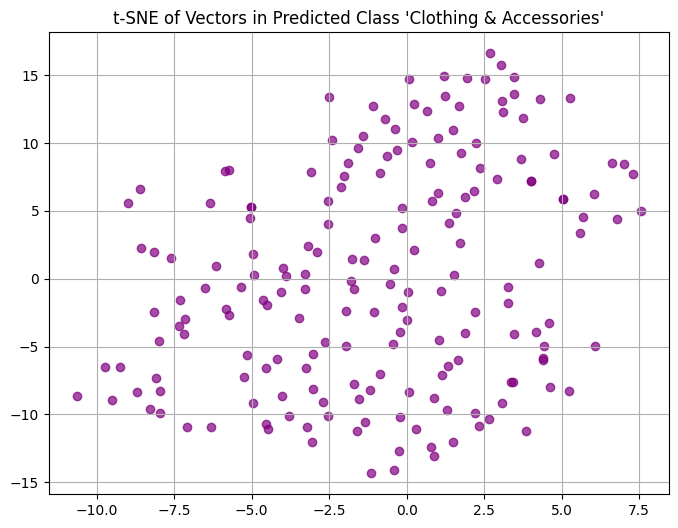

📝 Document 0
Text: Diverse Men's Formal Shirt Diverse is a western wear value brand for men. Our range consists of basic and updated basic apparel across both formal and casual wear. We offer the right blend of quality, style and value aimed to delight our customers.
True Label: Clothing & Accessories
Predicted Label: Clothing & Accessories

📝 Document 1
Text: Jack's Star Soft Cotton Track Pants for Kids Infants & Toddler - Lowers/Joggers for Boys and Girls with Bottom Ribs- Pack of 5
True Label: Clothing & Accessories
Predicted Label: Clothing & Accessories

📝 Document 9
Text: ROOLIUMS Ã‚ Brand Factory Outlet Women's Girls Stripe Tights for Yoga Gym and Active Sports Fitness
True Label: Clothing & Accessories
Predicted Label: Clothing & Accessories

📝 Document 10
Text: AAKRITHI Women Formal Blazer Aakrithi comes with its trendy dynamic fitting women Blazer with its unmatchable comfort level and unique colour combination which provide the feel of uniqueness and comfortness to its owner

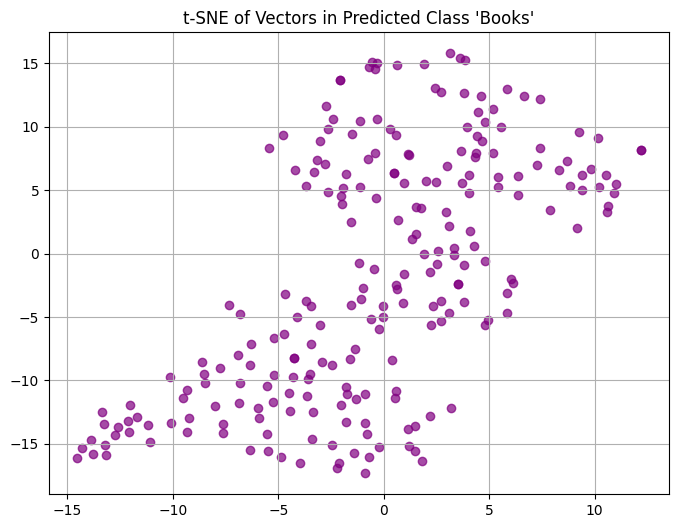

📝 Document 2
Text: UGC/NET/JRF/SET English Literature (Paper-II And III) UGC Pol Sci useful for DSSB KVS JNU etc
True Label: Books
Predicted Label: Books

📝 Document 7
Text: Pharmacology for Dentistry About the Author Tara V Shanbhag is Professor and Head at the Department of Pharmacology, Srinivas Institute of Medical Sciences and Research Centre, Mukka, Mangalore, Karnataka, India. She has a teaching experience of more than 30 years and has been an examiner to various universities. Dr Shanbhag is an honourable recipient of the ‘Good Teacher’ award. She has authored books on pharmacology and has to her credit several articles in national and international journals. Smita Shenoy is Additional Professor at the Department of Pharmacology, Kasturba Medical College, Manipal University, Manipal, Karnataka, India. She has 13 years of teaching experience and has been an examiner to various universities. Dr Shenoy has been honoured with the ‘Good Teacher’ award. She has authored books on pharm

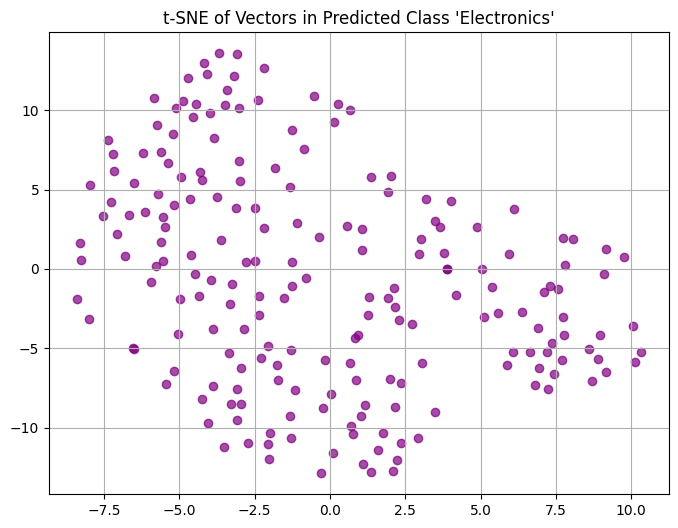

📝 Document 3
Text: MAA-KU AC Axial Cooling Blower Exhaust Rotary Fan, Size : 4.75" inches (12 x 12 x 3.8 cm), Black
True Label: Household
Predicted Label: Electronics

📝 Document 6
Text: Zoook Rocker Thunder 20 watts Bluetooth Speaker with Karaoke Mic/TF/FM/LED/USB/Party Speaker Zoook has upped its game again with the new rocker thunder. Rocker thunder brings together style, creativity and function. This portable sound machi is perfect for those summer time beach days. With the built-in Bluetooth capability, FM radio, aux-in, mic-in, usb and micro-SD inputs. You can enjoy music anyway want. Don't worry about a power outlet. The built-in rechargeable lithium battery allows you to listen to music for hours. Included microphone gets your karaoke nights started
True Label: Electronics
Predicted Label: Electronics

📝 Document 15
Text: Myra® TouYinGer X7 Led Projector 1800 Lumens, 800*600 HDMI USB VGA TV Home Cinema, Support Red & Blue 3D Format Resolution: Native : 800x600 support 720p 1080

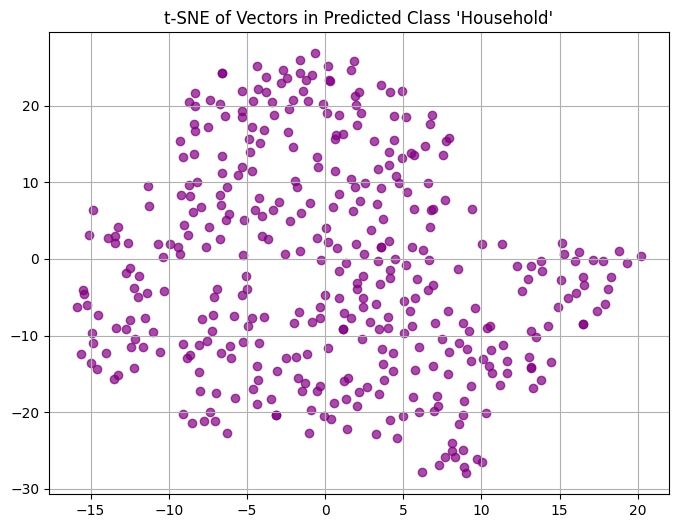

📝 Document 4
Text: Generic Super Soft Sheep Faux Fur Hairy Washable Pillow Chair Carpet Rugs Mat Specification: Ideal as a rug or draped across your favorite armchair. High quality floor carpets, also perfect for home decor. Suitable to use on tiles, wooden and laminate floors. Add a beautiful touch to any room in your home. Type: Rug Material: Imitation Wool Occasions: Bedroom, Dinning Room, Office, Living Room Features: Soft, Warm, Anti-Slip Size: 60cm x 90cm/23.62" x 35.43" (Approx.) Notes: Due to the light and screen setting difference, the item's color may be slightly different from the pictures. Please allow slight dimension difference due to different manual measurement. Package Includes: 1 x Rug
True Label: Household
Predicted Label: Household

📝 Document 5
Text: AmazonBasics 16 Piece Wood Suit Hanger, Cherry Size:16 Piece   Solid wood construction to hold your heaviest clothes;Designed with a chrome swivel hook;Precisely cut notches on each end allow for hanging straps;Product

In [23]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# ساخت df_test با ایندکس‌های درست
df_test = df.iloc[idx_test].reset_index(drop=True)
df_test["true_label"] = y_test.reset_index(drop=True)
df_test["pred_label"] = y_pred

# گرفتن لیست کلاس‌های پیش‌بینی‌شده
all_classes = df_test["pred_label"].unique()

for selected_class in all_classes:
    print(f"\n🔍 Predicted Class: {selected_class}")

    # فیلتر داده‌ها
    docs_in_class = df_test[df_test["pred_label"] == selected_class]
    X_class = X_test[df_test["pred_label"] == selected_class]

    # بررسی وجود داده
    if len(docs_in_class) == 0:
        print("⛔ No samples found for this class.")
        continue

    # کاهش ابعاد و رسم
    tsne = TSNE(n_components=2, random_state=42)
    X_2d = tsne.fit_transform(X_class.toarray() if hasattr(X_class, "toarray") else X_class)

    plt.figure(figsize=(8, 6))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], alpha=0.7, color='purple')
    plt.title(f"t-SNE of Vectors in Predicted Class '{selected_class}'")
    plt.grid(True)
    plt.show()

    # نمایش چند سند نمونه
    for i, row in docs_in_class.head(5).iterrows():
        print(f"📝 Document {i}")
        print("Text:", row["text"])
        print("True Label:", row["true_label"])
        print("Predicted Label:", row["pred_label"])
        print()


## word2vec


In [18]:
def document_vector(doc, model):
    doc = [word for word in doc if word in model.wv]
    return np.mean([model.wv[word] for word in doc], axis=0) if doc else np.zeros(model.vector_size)

X_w2v = np.array([document_vector(doc, model) for doc in sentences])


🧪 Random Forest
Accuracy: 0.916
                        precision    recall  f1-score   support

                 Books       0.96      0.91      0.93       237
Clothing & Accessories       0.94      0.90      0.92       189
           Electronics       0.88      0.92      0.90       202
             Household       0.89      0.93      0.91       372

              accuracy                           0.92      1000
             macro avg       0.92      0.91      0.92      1000
          weighted avg       0.92      0.92      0.92      1000
 

🧪 Linear SVC
Accuracy: 0.909
                        precision    recall  f1-score   support

                 Books       0.93      0.90      0.92       237
Clothing & Accessories       0.91      0.94      0.93       189
           Electronics       0.87      0.88      0.88       202
             Household       0.91      0.91      0.91       372

              accuracy                           0.91      1000
             macro avg       0.91   

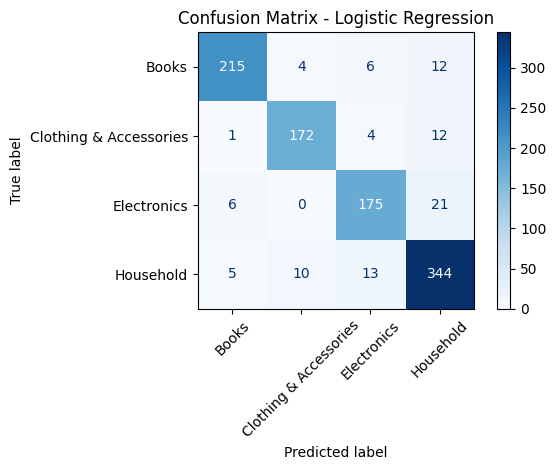

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

X = X_w2v
y = df["category"]

indices = np.arange(len(df))
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, indices, test_size=0.2, random_state=42
)

models = {
    "Random Forest": RandomForestClassifier(),
    "Linear SVC": LinearSVC(),
    # "MLP Classifier": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300)
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

for name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"🧪 {name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred), "\n")

    if name == "Logistic Regression":
      cm = confusion_matrix(y_test, y_pred)
      disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
      disp.plot(cmap='Blues', values_format='d')
      plt.title('Confusion Matrix - Logistic Regression')
      plt.xticks(rotation=45)
      plt.tight_layout()
      plt.show()



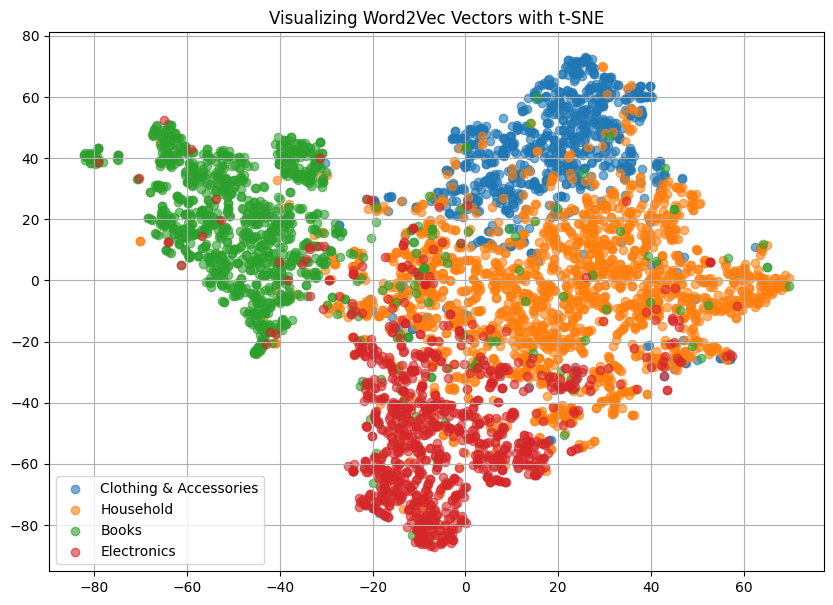

In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X_vis = X_w2v

# کاهش ابعاد با t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_2d = tsne.fit_transform(X_vis)

# رسم
plt.figure(figsize=(10, 7))
for label in df["category"].unique():
    indices = df["category"] == label
    plt.scatter(X_2d[indices, 0], X_2d[indices, 1], label=label, alpha=0.6)

plt.legend()
plt.title("Visualizing Word2Vec Vectors with t-SNE")
plt.grid(True)
plt.show()



🔍 Predicted Class: Books


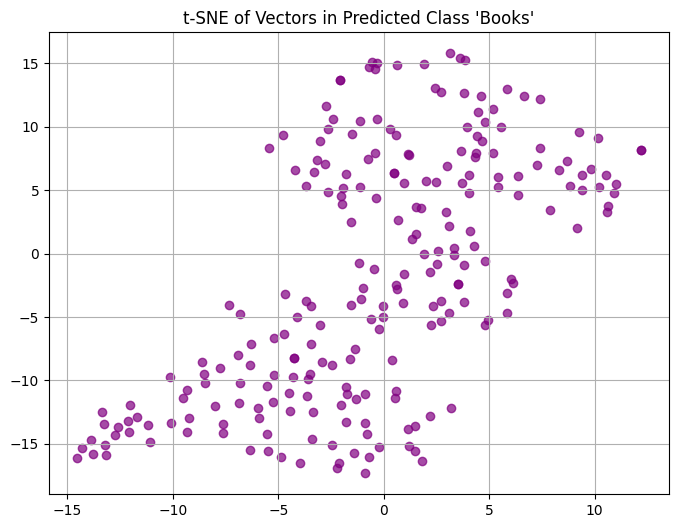

📝 Document 2
Text: UGC/NET/JRF/SET English Literature (Paper-II And III) UGC Pol Sci useful for DSSB KVS JNU etc
True Label: Books
Predicted Label: Books

📝 Document 7
Text: Pharmacology for Dentistry About the Author Tara V Shanbhag is Professor and Head at the Department of Pharmacology, Srinivas Institute of Medical Sciences and Research Centre, Mukka, Mangalore, Karnataka, India. She has a teaching experience of more than 30 years and has been an examiner to various universities. Dr Shanbhag is an honourable recipient of the ‘Good Teacher’ award. She has authored books on pharmacology and has to her credit several articles in national and international journals. Smita Shenoy is Additional Professor at the Department of Pharmacology, Kasturba Medical College, Manipal University, Manipal, Karnataka, India. She has 13 years of teaching experience and has been an examiner to various universities. Dr Shenoy has been honoured with the ‘Good Teacher’ award. She has authored books on pharm

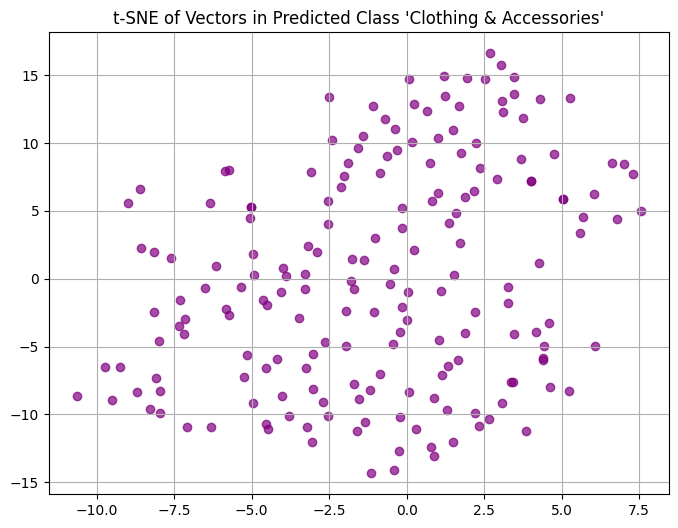

📝 Document 0
Text: Diverse Men's Formal Shirt Diverse is a western wear value brand for men. Our range consists of basic and updated basic apparel across both formal and casual wear. We offer the right blend of quality, style and value aimed to delight our customers.
True Label: Clothing & Accessories
Predicted Label: Clothing & Accessories

📝 Document 1
Text: Jack's Star Soft Cotton Track Pants for Kids Infants & Toddler - Lowers/Joggers for Boys and Girls with Bottom Ribs- Pack of 5
True Label: Clothing & Accessories
Predicted Label: Clothing & Accessories

📝 Document 9
Text: ROOLIUMS Ã‚ Brand Factory Outlet Women's Girls Stripe Tights for Yoga Gym and Active Sports Fitness
True Label: Clothing & Accessories
Predicted Label: Clothing & Accessories

📝 Document 10
Text: AAKRITHI Women Formal Blazer Aakrithi comes with its trendy dynamic fitting women Blazer with its unmatchable comfort level and unique colour combination which provide the feel of uniqueness and comfortness to its owner

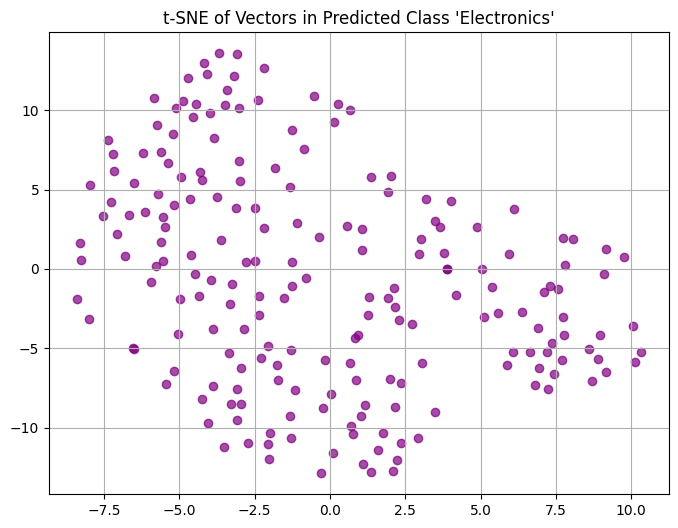

📝 Document 3
Text: MAA-KU AC Axial Cooling Blower Exhaust Rotary Fan, Size : 4.75" inches (12 x 12 x 3.8 cm), Black
True Label: Household
Predicted Label: Electronics

📝 Document 6
Text: Zoook Rocker Thunder 20 watts Bluetooth Speaker with Karaoke Mic/TF/FM/LED/USB/Party Speaker Zoook has upped its game again with the new rocker thunder. Rocker thunder brings together style, creativity and function. This portable sound machi is perfect for those summer time beach days. With the built-in Bluetooth capability, FM radio, aux-in, mic-in, usb and micro-SD inputs. You can enjoy music anyway want. Don't worry about a power outlet. The built-in rechargeable lithium battery allows you to listen to music for hours. Included microphone gets your karaoke nights started
True Label: Electronics
Predicted Label: Electronics

📝 Document 15
Text: Myra® TouYinGer X7 Led Projector 1800 Lumens, 800*600 HDMI USB VGA TV Home Cinema, Support Red & Blue 3D Format Resolution: Native : 800x600 support 720p 1080

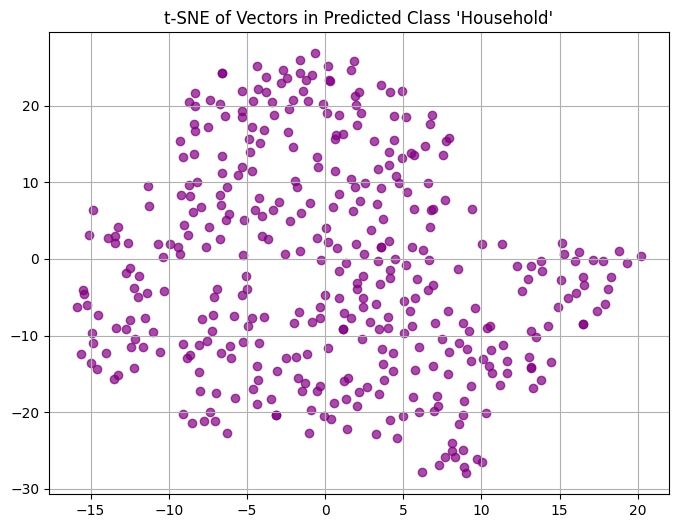

📝 Document 4
Text: Generic Super Soft Sheep Faux Fur Hairy Washable Pillow Chair Carpet Rugs Mat Specification: Ideal as a rug or draped across your favorite armchair. High quality floor carpets, also perfect for home decor. Suitable to use on tiles, wooden and laminate floors. Add a beautiful touch to any room in your home. Type: Rug Material: Imitation Wool Occasions: Bedroom, Dinning Room, Office, Living Room Features: Soft, Warm, Anti-Slip Size: 60cm x 90cm/23.62" x 35.43" (Approx.) Notes: Due to the light and screen setting difference, the item's color may be slightly different from the pictures. Please allow slight dimension difference due to different manual measurement. Package Includes: 1 x Rug
True Label: Household
Predicted Label: Household

📝 Document 5
Text: AmazonBasics 16 Piece Wood Suit Hanger, Cherry Size:16 Piece   Solid wood construction to hold your heaviest clothes;Designed with a chrome swivel hook;Precisely cut notches on each end allow for hanging straps;Product

In [25]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

selected_classes = ["Books", "Clothing & Accessories", "Electronics", "Household"]

for selected_class in selected_classes:
    print(f"\n🔍 Predicted Class: {selected_class}")

    # فیلتر داده‌ها
    docs_in_class = df_test[df_test["pred_label"] == selected_class]
    X_class = X_test[df_test["pred_label"] == selected_class]

    # بررسی وجود داده
    if len(docs_in_class) == 0:
        print("⛔ No samples found for this class.")
        continue

    # کاهش ابعاد و رسم
    tsne = TSNE(n_components=2, random_state=42)
    X_2d = tsne.fit_transform(X_class.toarray() if hasattr(X_class, "toarray") else X_class)

    plt.figure(figsize=(8, 6))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], alpha=0.7, color='purple')
    plt.title(f"t-SNE of Vectors in Predicted Class '{selected_class}'")
    plt.grid(True)
    plt.show()

    # نمایش چند سند
    for i, row in docs_in_class.head(5).iterrows():
        print(f"📝 Document {i}")
        print("Text:", row["text"])
        print("True Label:", row["true_label"])
        print("Predicted Label:", row["pred_label"])
        print()
